# Process Sitelle data <a class="tocSkip">
    
this notebook is used to try out stuff and not to produce science ready data

* [ORB](https://orb.readthedocs.io) documentation
* [ORCS](https://orcs.readthedocs.io/en/latest/index.html) documentation
* [ORBS](https://github.com/thomasorb/orbs) github

In [2]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

import sys
import logging
from pathlib import Path
import warnings

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table,join,vstack
from astropy.io import fits,ascii
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

In [3]:
plt.style.use('Tex.mplstyle')

logging.basicConfig(stream=sys.stdout,format='%(levelname)s: %(message)s',level=logging.INFO)
logger = logging.getLogger(__name__)

single_column = 3.321 # in inch
two_column    = 6.974 # in inch

basedir  = Path('.')
data_raw = Path('/mnt/g/') 

## Read in the data
it might be necassary to mount the external drive first
`sudo mount -t drvfs a: /mnt/g`

### first the SITELLE data

In [4]:
from orcs.process import SpectralCube
from astropy.nddata import NDData

name = 'NGC0628'

filename = data_raw / 'SITELLE' /f'{name}_cube.hdf5'
cube = SpectralCube(filename)
print(cube.params['object_name'])

# read in the deepframe file to get the correct 2d header
filename = data_raw/'SITELLE'/f'{name}_deepframe.fits'
#filename = Path(f'/mnt/g/SITELLE/{name}_deepframe.fits')
with fits.open(filename) as hdul:
    deepframe = NDData(data=hdul[0].data,
                    meta=hdul[0].header,
                    # for some reason the deepframe does not contain a valid WCS information
                    wcs=cube.get_wcs())    

INFO: Cube is level 1
INFO: shape: (2048, 2064, 105)
INFO: wavenumber calibration: True
INFO: flux calibration: True
INFO: wcs calibration: False
NGC628


In [5]:
# the WCS information in the fits cubes is correct
filename = data_raw/'SITELLE'/f'{name}_cube.fits'
with fits.open(filename) as hdul:
    header = hdul[0].header
wcs = WCS(header,naxis=2)
#cube.set_wcs(wcs)

In [ ]:
# save deepframe to file
deep = cube.get_deep_frame()
deep.to_fits(basedir/'SITELLE'/f'{name}_deepframe.fits')

### and the MUSE data

In [6]:
from astropy.table import Table 
from reproject import reproject_interp
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

DR = 'DR2'
if DR=='DR1':
    catalogue_file = data_raw/'MUSE_DR1'/'Nebulae catalogue'/'Nebulae_Catalogue.fits' 
    filter_file = data_raw/'MUSE_DR1'/'filterImages'/f'{name}_IMAGE_FOV_Johnson_B.fits'
    mask_file = data_raw/'MUSE_DR1'/'Nebulae catalogue'/'spatial_masks'/f'{name}_HIIreg_mask.fits'.format(name) 
else:
    catalogue_file = data_raw/'MUSE_DR2'/'Nebulae catalogue'/'Nebulae_Catalogue_DR2_native.fits' 
    filter_file = data_raw/'MUSE_DR2'/'filterImages'/f'{name}_IMAGE_FOV_Johnson_B_WCS_Pall_mad.fits'
    mask_file = data_raw/'MUSE_DR2'/'Nebulae catalogue'/'spatial_masks'/f'{name}_HIIreg_mask.fits'.format(name) 
print(f'using {DR}')
    
with fits.open(catalogue_file) as hdul:
    nebulae_catalogue = Table(hdul[1].data)
    
# muse image for reprojection
with fits.open(filter_file) as hdul:    
    muse_data = NDData(data=hdul['DATA'].data,
                    mask=np.isnan(hdul['DATA'].data),
                    meta=hdul['DATA'].header,
                    wcs=WCS(hdul['DATA'].header))    
    muse_data.data[muse_data.data==0] = np.nan

with fits.open(mask_file) as hdul:
    # -1 because the masks start with 1 instead of 0
    nebulae_mask = NDData(hdul[0].data-1,mask=muse_data.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
    
    #mask_muse = hdul[0].data-1
    #mask_muse_header = hdul[0].header
    #interpolated_mask, _ = reproject_interp(hdul, deepframe_header)
    #interpolated_mask=np.round(interpolated_mask,0)

nebulae_catalogue = nebulae_catalogue[nebulae_catalogue['gal_name']==name]
nebulae_catalogue.add_index('region_ID')
nebulae_catalogue['SkyCoord'] = SkyCoord(nebulae_catalogue['cen_ra']*u.degree,nebulae_catalogue['cen_dec']*u.degree)
print('{} nebulae in {}'.format(len(nebulae_catalogue),name))
print('{} regions in masks'.format(len(np.unique(nebulae_mask.data[~np.isnan(nebulae_mask.data)]))))

from region import Regions
        
muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)

using DR2
1818 nebulae in NGC0628
1818 regions in masks
INFO: initialized with 1818 regions


## Plot region contours over image

In [ ]:
muse_regions.plot(image=muse_data.data,regions=False,
                     filename=basedir/'reports'/name/f'{name}_muse_regions_DR1.pdf',
                     percent=98.5)

In [ ]:
from astropy.nddata import Cutout2D

# check if the position in the catalogue match the position in the mask
def plot_region(row,mask):
    
    print(row['region_ID'])
    
    cutout = Cutout2D(mask.data,row['SkyCoord'],3*u.arcsec,wcs=mask.wcs)
    
    print(np.unique(cutout.data[~np.isnan(cutout.data)]))
    
    fig,ax=plt.subplots()
    
    im = ax.imshow(cutout.data)
    
    plt.show()
    
plot_region(nebulae_catalogue[20],nebulae_mask)

In [ ]:
# determine the limits of the muse data in the sitelle image
a, footprint = reproject_interp(muse_data,output_projection=wcs,shape_out=cube.shape[:2])

xvalues = np.where(np.any(footprint,axis=0))
xmin,xmax = np.min(xvalues),np.max(xvalues)
yvalues = np.where(np.any(footprint,axis=1))
ymin,ymax = np.min(yvalues),np.max(yvalues)

In [ ]:
sitelle_regions = muse_regions.reproject(wcs,shape=cube.shape[:2])
sitelle_regions.plot(image=deepframe.data,regions=False,
                     filename=basedir/'reports'/name/f'{name}_sitelle_regions_{DR}.pdf',
                     xlim=[xmin,xmax],ylim=[ymin,ymax], 
                     percent=99.3)

### Plot deepframe and PHANGS data

In [ ]:
fig = plt.figure(figsize=(two_column,two_column/2.))
ax1 = fig.add_subplot(121, projection=wcs)
#ax1.coords[0].set_major_formatter('hh:mm:ss.s')
#ax1.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(deepframe.data,clip=False,max_percent=99)
ax1.imshow(deepframe.data,norm=norm,cmap='gray_r')
ax1.set_title('deep frame cube')

ax2 = fig.add_subplot(122, projection=muse_data.wcs)
ax2.coords[0].set_major_formatter('hh:mm:ss.s')
ax2.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(muse_data.data,clip=False,max_percent=99)
ax2.imshow(muse_data.data,norm=norm,cmap='gray_r')
ax2.set_title('MUSE r-band')

for ax in [ax1,ax2]:
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from reproject import reproject_interp
array, footprint = reproject_interp((deepframe.data,wcs), muse_data.meta)

fig = plt.figure(figsize=(two_column,two_column/2))

ax1 = fig.add_subplot(121, projection=muse_data.wcs)
norm = simple_norm(array,clip=False,max_percent=99)
ax1.imshow(array,norm=norm,cmap='gray_r')
#ax1.set_title('Sitelle deep frame')

ax2 = fig.add_subplot(122, projection=muse_data.wcs)
norm = simple_norm(muse_data.data,clip=False,max_percent=99)
ax2.imshow(muse_data.data,norm=norm,cmap='gray_r')
#ax2.set_title('MUSE r-band image')

for ax in [ax1,ax2]:
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)

plt.subplots_adjust(top=0.5)
plt.tight_layout()
plt.savefig(basedir/'img'/name/'sitelle_reprojected.pdf',bbox_inches='tight',dpi=600)

plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(111, projection=muse_data.wcs)
ax1.coords[0].set_major_formatter('hh:mm:ss.s')
ax1.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(array,clip=False,max_percent=99)
ax1.imshow(array,norm=norm,cmap='gray_r')

norm = simple_norm(muse_data.data,clip=False,max_percent=95)
ax1.imshow(muse_data.data,norm=norm,alpha=0.5,cmap='Reds_r')

plt.show()

see the MUSE data compared to the Sitelle data

## Fit line to data

### Define the relevant lines

the data has a peak at<br>
26738 1/cm = index 108 = 374.1 nm

but [OII] should be at<br>
26822 1/cm = index 114 = 372.8 nm



In [7]:
lines = ['[OII]3726','[OII]3729']
lam   = np.array([372.7319,372.9221])
wave  = (1/(lam*u.nm).to(u.cm))
wave

<Quantity [26828.93522127, 26815.25176438] 1 / cm>

In [8]:
k_min = cube.params['CRVAL3'] * 1/u.cm
d_k   = cube.params['CDELT3'] * 1/u.cm
steps = cube.params['step_nb']

wavenumbers = np.linspace(k_min,k_min+d_k*steps,steps)
wavelenghts = 1/wavenumbers

wavelenghts

<Quantity [3.88480883e-05, 3.88014519e-05, 3.87549274e-05, 3.87085143e-05,
           3.86622123e-05, 3.86160209e-05, 3.85699397e-05, 3.85239684e-05,
           3.84781065e-05, 3.84323537e-05, 3.83867096e-05, 3.83411738e-05,
           3.82957458e-05, 3.82504254e-05, 3.82052121e-05, 3.81601056e-05,
           3.81151055e-05, 3.80702114e-05, 3.80254229e-05, 3.79807397e-05,
           3.79361614e-05, 3.78916875e-05, 3.78473179e-05, 3.78030520e-05,
           3.77588896e-05, 3.77148302e-05, 3.76708735e-05, 3.76270192e-05,
           3.75832668e-05, 3.75396161e-05, 3.74960667e-05, 3.74526182e-05,
           3.74092702e-05, 3.73660225e-05, 3.73228747e-05, 3.72798264e-05,
           3.72368773e-05, 3.71940270e-05, 3.71512753e-05, 3.71086217e-05,
           3.70660659e-05, 3.70236076e-05, 3.69812465e-05, 3.69389823e-05,
           3.68968145e-05, 3.68547428e-05, 3.68127671e-05, 3.67708868e-05,
           3.67291017e-05, 3.66874114e-05, 3.66458157e-05, 3.66043142e-05,
           3.65629066e-05

the spectra in the data cube will be redshifted

$$
z = \frac{\lambda_\text{obs}}{\lambda_0}-1 \quad \rightarrow \quad \lambda_0 = \frac{\lambda_\text{obs}}{1+z}
$$
note that the cube is in wavenumbers (1/cm). This means we need to multiply with $1+z$ instead

In [9]:
from astropy.coordinates import Distance

@u.quantity_input(distance='length', velocity='speed')
def calculate_redshift(distance=None,velocity=None):
    '''Calculate the redshift from a given distance or velocity
        
    v = D * H0
    
    z = v / c
    
    z = l_obs / l_0 - 1

    
    distance:
        distance to the object
    
    velocity:
        recessional velocity 
    '''
    
    H0 = 70 * u.km / u.s / u.Mpc
    c  = 299792458 * u.m/u.s

    if not isinstance(distance,astropy.coordinates.distances.Distance) and not isinstance(velocity,astropy.units.quantity.Quantity):
        raise ValueError('need either distance or velocity')
    
    if isinstance(distance,astropy.coordinates.distances.Distance):
        velocity = H0 * distance 
        
    z = velocity / c
    
    return z.decompose()

if name == 'NGC2835':
    z=calculate_redshift(Distance(12.38*u.Mpc))
elif name == 'NGC4535':
    z=calculate_redshift(distance=Distance(distmod=30.99))
elif name == 'NGC3351':
    z=calculate_redshift(distance=Distance(distmod=30.116))
elif name == 'NGC0628':
    z=calculate_redshift(distance=Distance(distmod=29.9))
else:
    raise ValueError('unkown galaxy: '+name)

print('z={:.4f} for {}'.format(z,name))

z=0.0022 for NGC0628


### Fit single spectrum

line velocity

In [10]:
# it could be directly computed with the following formula
c = 3e5 # lightspeed in km/s
channel_width = cube.params.base_axis[1] - cube.params.base_axis[0]
print(f'channel width in km/s at the mean wavenumber of the axis: {c * channel_width / wave[1].value:.2f}')

channel width in km/s at the mean wavenumber of the axis: 342.84


x,y=1076.0,258.4
 [==========] [100%] [completed in 0.040 s]                                   
Velocity (km/s):  [165(125) 165(125)]
Broadening (km/s) [nan +- nan nan +- nan]
flux: 2.26e-17,3.17e-17


/home/fabian/miniconda3/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


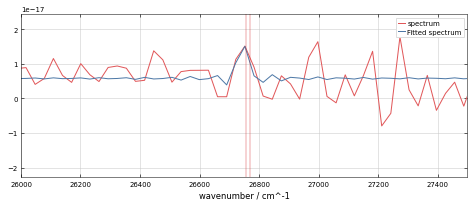

In [53]:
# set up the fit to check if before running the long extraction process over the whole ROI
vel = 80
if name=='NGC2835':
    x,y = 895, 1014   # for NGC2835
elif name=='NGC4535':
    x,y = 500,503      # for NGC4535
elif name=='NGC0628':
    RA, DEC = 24.193673,15.74246
    pos = SkyCoord(RA*u.degree,DEC*u.degree)
    x,y=pos.to_pixel(wcs)

    print(f'x,y={x:.1f},{y:.1f}')
else:
    print('specify x,y')
    
k1,k2 = wave.value/(1+z)
amp_ratio = cube.get_amp_ratio_from_flux_ratio(k1,k2,1.4)

axis, spectrum, fit = cube.fit_lines_in_spectrum(x,y, 2,
                                                 [k1,k2],
                                                 fmodel='sinc',
                                                 pos_def=['1','1'],
                                                 pos_cov=[vel],
                                                 amp_def=['1','1'],
                                                 amp_guess=[1, amp_ratio],
                                                 snr_guess=None,
                                                 nofilter=True)

print('Velocity (km/s): ', fit['velocity_gvar'])
print('Broadening (km/s)', fit['broadening_gvar'])
new_vel = fit['velocity'][0], fit['velocity'][1]
print('flux: {:.3g},{:.3g}'.format(*fit['flux']))

plt.figure(figsize=(8,3))
plt.plot(axis, spectrum, label='spectrum')
plt.plot(axis, fit['fitted_vector'], label='Fitted spectrum')

for x in wave.value:
    plt.axvline(x/(1+z),linewidth=0.4,color='tab:red')
plt.xlabel('wavenumber / cm^-1')
    
#pl.plot(axis, fit['fitted_vector'], label='fitted model')
plt.xlim((26000,27500))
plt.legend()
plt.grid()

In [50]:
fit['flux']

array([6.81998868e-17])

### Fit lines in  integrated region (from Nebulae catalogue)

In [6]:
lines = ['[OII]3726', '[OII]3729']
lam   = np.array([372.7319,372.9221])
wave  = (1/(lam*u.nm).to(u.cm))

# set up the fit to check if before running the long extraction process over the whole ROI
vel = 80
k1,k2 = wave.value/(1+z)
amp_ratio = cube.get_amp_ratio_from_flux_ratio(k1,k2,1.4)

NameError: name 'z' is not defined

In [ ]:
sitelle_regions = muse_regions.reproject(wcs,shape=cube.shape[:2])

 we first test with one single region

In [ ]:
reg = sitelle_regions.coords[1]
axis, spectrum, fit_dict = cube.fit_lines_in_integrated_region(reg,
                                                               [k1,k2],
                                                               fmodel='sinc',
                                                               pos_def=['1','1'],
                                                               pos_cov=[vel],
                                                               amp_def=['1','1'],
                                                               amp_guess=[1, amp_ratio],
                                                               snr_guess=None,
                                                               nofilter=False                                        
                                                              )

# or to extract spectra
#a,s = cube.extract_integrated_spectrum(sitelle_regions.coords[4])
# mean,median,std=sigma_clipped_stats(s[(a>26000) & (a<27500)])

plt.figure(figsize=(12,3))
plt.plot(axis, spectrum, label='spectrum')
plt.plot(axis, fit_dict['fitted_vector'], label='Fitted spectrum')

and now for the entire catalogue

In [ ]:
import time
from astropy.table import Table
from astropy.io import fits

def measure_flux_in_regions(cube,regions,labels):
    '''measure the fluxes in `regions` and save the result (plus spectrum) to a file
    '''
    
    start_time = time.time()
    vel = 80
    k1,k2 = wave.value/(1+z)
    amp_ratio = cube.get_amp_ratio_from_flux_ratio(k1,k2,1.4)
    
    # create dict to save output
    result = {
      'gal_name' : [],
      'region_ID' : [], 
      'cen_x' : [],
      'cen_y' : [],
      'region_area' : [],
      'OII3727_FLUX' : [],
      'OII3729_FLUX' : [],
      'OII3727_FLUX_ERR' : [],
      'OII3729_FLUX_ERR' : [],    
    }
    
    # lists to save complete spectra
    region_id = []
    axis      = []
    spectrum  = []
    fit       = []
    fit_err   = []
    
    logger.info('measuring fluxes in {} regions'.format(len(regions)))
    
    i = 1
    for r,l in zip(regions,labels):
        print('measuring region {} of {}'.format(i,len(regions)))
        i+=1 
        a, s, f = cube.fit_lines_in_integrated_region(
                                           r,
                                           [k1,k2],
                                           fmodel='sinc',
                                           pos_def=['1','1'],
                                           pos_cov=[vel],
                                           amp_def=['1','1'],
                                           amp_guess=[1, amp_ratio],
                                           snr_guess=None,
                                           nofilter=False                                        
                                                     )
        # previous run for NGC2835 used nofilter=True
        
        # save result to table
        cen_x,cen_y = np.array(r).mean(axis=1)
        result['gal_name'].append(name)
        result['region_ID'].append(l)
        result['cen_x'].append(cen_x)
        result['cen_y'].append(cen_y)
        result['region_area'].append(len(r[0]))
        result['OII3727_FLUX'].append(f['flux'][0])
        result['OII3729_FLUX'].append(f['flux'][1])
        result['OII3727_FLUX_ERR'].append(f['flux_err'][0])
        result['OII3729_FLUX_ERR'].append(f['flux_err'][1])
             
        region_id.append(l)
        axis.append(np.float64(a))
        spectrum.append(np.real(s))
        fit.append(f['fitted_vector'])
        fit_err.append(f['fitted_vector_gvar'])
            
        if np.any(np.imag(s)):
            print(f'imaginary spectrum for id={region_ID}')

    logger.info('fluxes measured for all regions')
    
    # table with condensed output
    result = Table(result,names=('gal_name','region_ID','cen_x','cen_y','region_area',
                   'OII3727_FLUX','OII3729_FLUX','OII3727_FLUX_ERR','OII3729_FLUX_ERR'))
    
    # format columns
    result['cen_x'].info.format = '%.2f'
    result['cen_y'].info.format = '%.2f'    
    for col in ['OII3727_FLUX','OII3729_FLUX','OII3727_FLUX_ERR','OII3729_FLUX_ERR']:
        result[col] *= u.erg / u.cm**2 / u.s
        result[col].info.format = '%.3e'
    
    # write to file
    hdu = fits.BinTableHDU(result,name='fluxes')
    hdu.writeto(basedir/'data'/f'{name}_nebulae_OII_{DR}.fits',overwrite=True)
    
    # table with the full spectral information
    
    # this format uses a separate extension for axis, spectrum etc. 
    #primary_hdu = fits.PrimaryHDU()
    #hdul = fits.HDUList([primary_hdu])
    #hdul.append(fits.BinTableHDU(Table(axis,names=region_id),name='axis'))
    #hdul.append(fits.BinTableHDU(Table(spectrum,names=region_id),name='spectrum'))
    #hdul.append(fits.BinTableHDU(Table(fit,names=region_id),name='fit'))
    #hdul.append(fits.BinTableHDU(Table(fit_err,names=region_id),name='fit_err'))
    
    spectra = Table(data=[region_id,axis,spectrum,fit,fit_err],
                    names=['region_ID','axis','spectrum','fit','fit_err'])
    spectra['axis'] /= u.cm
    spectra['spectrum'] *= u.erg/u.cm**2/u.s/u.AA
    spectra['fit'] *= u.erg/u.cm**2/u.s/u.AA
    spectra['fit_err'] *= u.erg/u.cm**2/u.s/u.AA
    
    hdu = fits.BinTableHDU(spectra,name='spectra')
    hdu.writeto(basedir/'data'/'spectra'/f'{name}_spectra_OII_{DR}.fits',overwrite=True)
    
    
    print('done in {}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start_time))))

    return result, spectra
        
result,spectra = measure_flux_in_regions(cube,sitelle_regions.coords,sitelle_regions.labels)

### Fit entire image (from DS9 region)

[see here](https://orcs.readthedocs.io/en/latest/examples/fit_region.html)

we cover a region between 350 and 400 nm

| NAME | Air Wavelength |
|------|----------------|
|[OII]3726 |	372.7319|
|[OII]3727 |	372.7319|
|[OII]3729 |	372.9221|
|[NeIII]3869 |	386.876 |


In [ ]:
import pyregion
# define a region in ds9 and hten read it here
# this uses the wrong WCS information (maybe it does not matter because DS9 also uses the wrong WCS)
r = pyregion.open(basedir/'data'/'regions'/f'{name}.reg').as_imagecoord(deepframe.meta)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111, projection=deepframe.wcs)
ax1.coords[0].set_major_formatter('hh:mm:ss.s')
ax1.coords[1].set_major_formatter('dd:mm:ss')

ax1.imshow(deepframe.data, 
          vmin=np.nanpercentile(deepframe.data, 0.1),
          vmax=np.nanpercentile(deepframe.data, 99.9),
          cmap='gray_r')
ax1.set_title(name,pad=20)

patch_list, artist_list = r.get_mpl_patches_texts()

# ax is a mpl Axes object
for p in patch_list:
    ax1.add_patch(p)
for t in artist_list:
    ax1.add_artist(t)

fig.tight_layout()
plt.show()


In [ ]:
vel = 220
orb.core.Logger(debug=False)
cube.fit_lines_in_region(basedir/'data'/'regions'/f'{name}.reg',
                         wave[1:].value/(1+z),
                         fmodel='sinc',
                         pos_def=['1','1'],
                         pos_cov=[vel],
                         amp_def=['1','1'],
                         amp_guess=[1, amp_ratio],
                         binning=3, snr_guess=None,
                         nofilter=True)

#### Save to file, reprojected to MUSE

In [ ]:
from reproject import reproject_interp, reproject_exact

def combine_fits(name,folder,output_projection):
    '''combine the different linemaps into one fits file
    
    
    '''
    
    if not folder.is_dir():
        raise IOError('folder does not exist')

    data = []
    data_header = []
    err  = []
    err_header = []
    
    # so astropy doesn't warn us that the wcs contains unused sip information
    logger = logging.getLogger('astropy')
    logger.setLevel(logging.WARNING)  
    
    for flux_file in [x for x in (folder / 'MAPS').iterdir() if x.name.endswith('flux.fits')]:
        err_file = flux_file.with_name(flux_file.stem + '-err.fits')
        
        with fits.open(flux_file) as hdul:
            linemap, _ = reproject_exact(hdul, output_projection)
            data.append(linemap)
            data_header.append(hdul[0].header)
            
        with fits.open(err_file) as hdul:
            linemap, _ = reproject_exact(hdul, output_projection)
            err.append(linemap)
            err_header.append(hdul[0].header)         
         
    object_name = name
    print(str(len(data)) + ' linemaps found for ' + object_name)

    
    keywords = ['PROGRAM','DATE','OBSERVAT','TELESCOP','INSTRUME','MJD-OBS','DATE-OBS']

    primary_header = fits.Header()
    for card in data_header[0].cards:
        if card[0] in keywords:
            primary_header.append(card)
    
    l = float(data_header[0]['FILETYPE'].split(' ')[-1])/(1+z)
    
    # get this from somewhere else
    primary_header.insert('PROGRAM ',('OBJECT',object_name,'Object Name'))
        
    primary_hdu = fits.PrimaryHDU(header=primary_header)
    hdul = fits.HDUList([primary_hdu]) 
    print('primary extension created')
    
    for d,dh,e,eh in zip(data,data_header,err,err_header):
        
        # get the original wavelength of the line
        l = float(dh['FILETYPE'].split(' ')[-1])/(1+z)
        header = WCS(output_projection).to_header()
        header['BITPIX'] = (-32,'array data type')
        header.insert(0,('FILETYPE','Map flux {:.0f}'.format(l)))
        header.append()
        
        hdu = fits.ImageHDU(data=d,header=header,name='OII{:.0f}'.format(l))
        hdul.append(hdu)
        
        header['FILETYPE'] = 'Map flux error {:.0f}'.format(l)
        hdu = fits.ImageHDU(data=e,header=header,name='OII{:.0f}_err'.format(l))
        hdul.append(hdu)
        
        #single = fits.PrimaryHDU(d)
        #single.writeto('[OII]{:.0f}.fits'.format(l))
        
    print('all extensions created')
    
    hdul.writeto('data/{}_OII_maps.fits'.format(object_name),overwrite=True)
    print('saved to file')
    
    return hdul
#combine_fits(Path('NGC2835_SN1.1.0.ORCS'),muse_header)
hdul = combine_fits(name,Path('M95_SN1.1.0.ORCS'),muse_header)


In [ ]:
with fits.open('data/M95_OII_maps.fits') as hdul:
    h0 = hdul[0].header
    OII_header = hdul[1].header
    
    OII3727 = hdul['OII3727'].data
    OII3727_err = hdul['OII3727_ERR'].data
    OII3729 = hdul['OII3729'].data
    OII3729_err = hdul['OII3729_ERR'].data

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1  = fig.add_subplot(131, projection=WCS(OII_header))
ax1.coords[0].set_major_formatter('hh:mm:ss.s')
ax1.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(muse_data,'linear',clip=False,percent=99)
ax1.imshow(muse_data,norm=norm,cmap='gray')

ax1.set_title('MUSE')

ax2  = fig.add_subplot(132, projection=WCS(OII_header))
ax2.coords[0].set_major_formatter('hh:mm:ss.s')
ax2.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(OII3729,'linear',clip=False,percent=99)
ax2.imshow(OII3729,norm=norm,cmap='Blues',alpha=1)

ax2.set_title('SITELLE')

ax3  = fig.add_subplot(133, projection=WCS(OII_header))
ax3.coords[0].set_major_formatter('hh:mm:ss.s')
ax3.coords[1].set_major_formatter('dd:mm:ss')


norm = simple_norm(muse_data,'linear',clip=False,percent=99)
ax3.imshow(muse_data,norm=norm,cmap='gray',alpha=1)
norm = simple_norm(OII3729,'linear',clip=False,percent=99)
ax3.imshow(OII3729,norm=norm,cmap='Blues',alpha=0.6)

ax3.set_title('combined')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.show()

In [ ]:
OIIsum = np.sum(cube[:,:,108:110],axis=2)

In [ ]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131, projection=WCS(deep_frame_header))
ax1.coords[0].set_major_formatter('hh:mm:ss.s')
ax1.coords[1].set_major_formatter('dd:mm:ss')

ax1.imshow(deep_frame, 
          vmin=np.nanpercentile(deep_frame, 0.1),
          vmax=np.nanpercentile(deep_frame, 99.9),
          cmap='gray_r')
patch_list, artist_list = r.get_mpl_patches_texts()
# ax is a mpl Axes object
for p in patch_list:
    ax1.add_patch(p)
for t in artist_list:
    ax1.add_artist(t)
    
ax2 = fig.add_subplot(132, projection=WCS(OII_header))
ax2.coords[0].set_major_formatter('hh:mm:ss.s')
ax2.coords[1].set_major_formatter('dd:mm:ss')
norm = simple_norm(OII3729,'linear',clip=False,percent=99)
ax2.imshow(OII3729,norm=norm,cmap='Blues',alpha=1)

ax3 = fig.add_subplot(133, projection=WCS(deep_frame_header))
ax3.coords[0].set_major_formatter('hh:mm:ss.s')
ax3.coords[1].set_major_formatter('dd:mm:ss')
norm = simple_norm(OIIsum,'linear',clip=False,percent=99)
ax3.imshow(OIIsum.T,norm=norm,cmap='Blues',alpha=1)

ax1.coords[0].set_ticks(number=2)
ax2.coords[0].set_ticks(number=2)
ax3.coords[0].set_ticks(number=2)
ax2.coords[1].set_ticklabel_visible(False)
ax3.coords[1].set_ticklabel_visible(False)

plt.tight_layout()

ax1.set(xlim=[700,1400],ylim=[600,1500],title='whitelight',xlabel='R.A. (J2000)',ylabel='Dec. (J2000)')
ax2.set(title='[OII] from fit',xlabel='R.A. (J2000)')
ax3.set(xlim=[700,1400],ylim=[600,1500],title='[OII] from sum',xlabel='R.A. (J2000)')
#ax2.set(xlim=[60,140],ylim=[50,150])

plt.show()

## Read catalogue and spectra from file

In [1]:
name = 'NGC0628'

In [7]:
with fits.open('data/{}_nebulae_OII.fits'.format(name)) as hdul:
    result = Table(hdul[1].data)
with fits.open('data/spectra/{}_spectra_OII.fits'.format(name)) as hdul:
    spectra = Table(hdul[1].data)
result.add_index('region_ID')
spectra.add_index('region_ID')

In [10]:
result.sort('OII3727_FLUX')
result

gal_name,region_ID,cen_x,cen_y,region_area,OII3727_FLUX,OII3729_FLUX,OII3727_FLUX_ERR,OII3729_FLUX_ERR
str7,int64,float64,float64,int64,float64,float64,float64,float64
NGC0628,859,712.1,1570.6666666666667,30,-6.933317645684404e-17,-9.726472547428508e-17,3.010270429556809e-17,4.222987347427366e-17
NGC0628,1237,330.2068965517241,1153.5172413793102,29,-5.635662280955369e-17,-7.906044012913503e-17,2.620677460186657e-17,3.6764430356131504e-17
NGC0628,392,616.8105263157895,1131.2736842105264,95,-5.4286659356034903e-17,-7.61565716301398e-17,5.618595696646742e-17,7.882101988007207e-17
NGC0628,529,1045.6857142857143,1415.95,140,-5.167602007602778e-17,-7.249421075388121e-17,7.692086194316528e-17,1.0790918435425037e-16
NGC0628,984,488.3888888888889,1313.2222222222222,18,-5.072766158731986e-17,-7.116379676206303e-17,2.2793569942967798e-17,3.197618277970636e-17
NGC0628,623,634.734375,1115.28125,64,-4.9743853482186177e-17,-6.978365192873402e-17,5.11548734206154e-17,7.176311506548336e-17
NGC0628,601,683.741935483871,1271.1129032258063,62,-4.846734271557704e-17,-6.799288630073067e-17,4.159101587764865e-17,5.834636386599309e-17
NGC0628,129,651.1714285714286,1298.3238095238096,105,-4.7701094201149284e-17,-6.691794706947699e-17,5.82869128026733e-17,8.176836634658451e-17
NGC0628,874,544.0,1253.7179487179487,39,-4.7202410993397604e-17,-6.621836444858273e-17,3.5066941391519136e-17,4.919400209208599e-17


In [ ]:
result[result['OII3729_FLUX']/result['OII3729_FLUX_ERR']>3]

In [ ]:
def plot_spectrum(axis,spectrum,fit=np.array([]),fit_err=np.array([])):
    
    fig = plt.figure(figsize=(12,3))
    ax  = fig.add_subplot(111)

    ax.plot(axis, spectrum, label='spectrum')
    if len(fit)>0:
        ax.plot(axis, fit, label='Fitted spectrum')
        if len(fit_err)>0:
            ax.fill_between(axis,fit - fit_err, fit + fit_err, color='tab:orange',alpha=0.2)

    for x in wave.value:
        ax.axvline(x/(1+z),linewidth=0.4,color='tab:red')
    
    ax.set(xlabel='wavenumber / cm^-1',
           xlim=(26000,27500))
    plt.legend()
    plt.grid()
    plt.show()
 

row = spectra.loc[0]
plot_spectrum(row['axis'],row['spectrum'],row['fit'],row['fit_err'])

In [ ]:
nebulae_catalogue.loc[59]['HA6562_FLUX']

In [ ]:
nebulae_catalogue.loc[l]['HA6562_FLUX']

In [ ]:
sitelle_regions = muse_regions.reproject(wcs,shape=cube.shape[:2])

OII_map = np.zeros_like(muse_data.data)
for r,l in zip(muse_regions.coords,muse_regions.labels):
    OII_map[r] = result.loc[l]['OII3729_FLUX']
OII_map[OII_map==0] = np.nan

HA_map = np.zeros_like(muse_data.data)

for r,l in zip(muse_regions.coords,muse_regions.labels):
    HA_map[r] = nebulae_catalogue.loc[l]['HA6562_FLUX']*1e-20
HA_map[HA_map==0] = np.nan

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111,projection=muse_data.wcs)
ax1.coords[0].set_major_formatter('hh:mm:ss.s')
ax1.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(muse_data.data,stretch='asinh',clip=False,percent=98)
ax1.imshow(muse_data.data,norm=norm,cmap=plt.cm.gray)  

norm = simple_norm(OII_map,'linear',clip=False,percent=99)
im = ax1.imshow(OII_map,norm=norm,alpha=0.8,cmap=plt.cm.Reds)

for cont in muse_regions.contours:
    ax1.plot(cont[:,1], cont[:,0], 'k-',lw=0.2)

fig.colorbar(im,fraction=0.045, pad=0.07,label='flux / (erg/s/cm2)',ax=ax1)
ax1.set(xlabel='R.A.',ylabel='Dec.',title='[OII]3729 Sitelle')

'''
ax2  = fig.add_subplot(122,projection=muse_regions.wcs)
ax2.coords[0].set_major_formatter('hh:mm:ss.s')
ax2.coords[1].set_major_formatter('dd:mm:ss')

norm = simple_norm(muse_data,'linear',clip=False,percent=99)
ax2.imshow(muse_data,norm=norm,cmap=plt.cm.gray) 

norm = simple_norm(HA_map,'linear',clip=False,min_cut=1e-15,max_cut=1e-13)
im = ax2.imshow(HA_map,norm=norm,alpha=0.8,cmap=plt.cm.Reds)

for cont in muse_regions.contours:
    ax2.plot(cont[:,1], cont[:,0], 'k-',lw=0.2)

fig.colorbar(im,fraction=0.045, pad=0.05,label='flux / (erg/s/cm2)',ax=ax2)
ax2.set(xlabel='R.A.',ylabel='Dec.',title='HA6562 MUSE')
'''

plt.tight_layout()

#plt.savefig(basedir/'img'/name/f'{name}_OII_flux.png',dpi=600)
plt.savefig(basedir/'img'/name/f'{name}_OII_flux.pdf',dpi=600)
plt.show()        